In [1]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from IPython.display import display, HTML
import re

project_root = "/home/ubuntu/VOCAL-UDF/"

config = yaml.safe_load(open(os.path.join(project_root, "configs", "config.yaml"), "r"))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def prepare_plot_data(plot_data, count_data, dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name):
    # Define LLM models, tasks, number of new UDFs, and hatch patterns
    selection_methods = ['All', 'No Active Learning', 'No Dummy UDF']

    # hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    # handles_f1 = []

    # Create a figure and axis for the boxplot
    # fig, ax = plt.subplots(1, 1, figsize=(3, 2))  # Adjust the figsize as needed

    # Iterate through LLM models
    for i, selection_method in enumerate(selection_methods):
        print(f"######## {selection_method} ########")

        # Iterate through tasks
        for task_id in num_new_udfs:
            task = f"{task_id}_new_udfs"
            failed_list = []

            # Iterate through runs and questions
            for query_class_name in query_class_names:
                for run_id in run_ids:
                    for question_id in question_ids:
                        try:
                            if selection_method == 'All':
                                config_name = vocal_udf_config_name
                            elif selection_method == 'No Active Learning':
                                config_name = f"random_{vocal_udf_config_name}"
                            elif selection_method == 'No Dummy UDF':
                                config_name = f"no_dummy_{vocal_udf_config_name}"
                            with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                lines = f.readlines()
                            f1_score = -1
                            for line in lines:
                                if "F1 score:" in line:
                                    f1_score_pattern = r"F1 score: ([0-9.]+)"
                                    match = re.search(f1_score_pattern, line)
                                    f1_score = float(match.group(1))
                                    failed_list.append(0)
                                    break
                            if f1_score == -1:
                                print(f"failed task: dataset={dataset}, task_id={task_id}, query_class_name={query_class_name}, question_id={question_id}, run_id={run_id}")
                                failed_list.append(1)
                                f1_score = 0
                            # dataset, query_class_names, num_new_udfs, question_ids, run_ids, f1_score
                            plot_data.append([selection_method, dataset, query_class_name, task_id, question_id, run_id, f1_score])
                        except Exception as e:
                            print(e)
                            continue

    # Count of active learning and random sampling
    print("######## Random Count ########")
    # Iterate through tasks
    for task_id in num_new_udfs:
        task = f"{task_id}_new_udfs"
        # Iterate through runs and questions
        for query_class_name in query_class_names:
            for run_id in run_ids:
                for question_id in question_ids:
                    try:
                        config_name = f"random_count_{vocal_udf_config_name}"
                        with open(os.path.join(config['log_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={task_id}", config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                        for line in lines:
                            pattern = re.compile(
                                r"\[(.*?)\]\s+"
                                r"# active positive:\s*(\d+),\s*"
                                r"# active negative:\s*(\d+),\s*"
                                r"# active total:\s*(\d+),\s*"
                                r"# random positive:\s*(\d+),\s*"
                                r"# random negative:\s*(\d+),\s*"
                                r"# random total:\s*(\d+)"
                            )
                            match = pattern.search(line)
                            if match:
                                udf_name = match.group(1)
                                random_positive = int(match.group(5))
                                random_negative = int(match.group(6))
                                random_total = int(match.group(7))
                                if random_positive > 10 and random_negative == 3:
                                    print(f"[random_negative==3] dataset={dataset}, query_class_name={query_class_name}, task_id={task_id}, question_id={question_id}, run_id={run_id}")
                                if udf_name in ["near", "far", "behind", "right_of", "location_right", "location_bottom", "to_the_left_of", "to_the_right_of", "in_front_of", "beneath", "in"]:
                                    count_data.append(["random", "easy", udf_name, dataset, query_class_name, task_id, question_id, run_id, random_positive, random_negative, random_total])
                                elif udf_name in ["color_brown", "color_cyan", "color_purple", "color_yellow", "shape_cylinder", "material_metal", "sedan", "black", "red", "blue", "pickup_truck", "holding", "sitting_on", "standing_on", "covered_by", "carrying", "eating", "wiping", "have_it_on_the_back"]:
                                    count_data.append(["random", "hard", udf_name, dataset, query_class_name, task_id, question_id, run_id, random_positive, random_negative, random_total])
                                else:
                                    raise ValueError(f"Unknown udf_name: {udf_name}")
                    except Exception as e:
                        print(e)
                        continue

    print("######## Active Count ########")
    # Iterate through tasks
    for task_id in num_new_udfs:
        task = f"{task_id}_new_udfs"
        # Iterate through runs and questions
        for query_class_name in query_class_names:
            for run_id in run_ids:
                for question_id in question_ids:
                    try:
                        config_name = f"active_learning_count_{vocal_udf_config_name}"
                        with open(os.path.join(config['log_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={task_id}", config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                        for line in lines:
                            # [behind] # active positive: 10, # active negative: 3, # active total: 13
                            pattern = re.compile(
                                r"\[(.*?)\]\s+"
                                r"# active positive:\s*(\d+),\s*"
                                r"# active negative:\s*(\d+),\s*"
                                r"# active total:\s*(\d+)"
                            )
                            match = pattern.search(line)
                            if match:
                                udf_name = match.group(1)
                                active_positive = int(match.group(2))
                                active_negative = int(match.group(3))
                                active_total = int(match.group(4))
                                if active_positive > 10 and active_negative == 3:
                                    print(f"[active_negative==3] dataset={dataset}, query_class_name={query_class_name}, task_id={task_id}, question_id={question_id}, run_id={run_id}")
                                if udf_name in ["near", "far", "behind", "right_of", "location_right", "location_bottom", "to_the_left_of", "to_the_right_of", "in_front_of", "beneath", "in"]:
                                    count_data.append(["active", "easy", udf_name, dataset, query_class_name, task_id, question_id, run_id, active_positive, active_negative, active_total])
                                elif udf_name in ["color_brown", "color_cyan", "color_purple", "color_yellow", "shape_cylinder", "material_metal", "sedan", "black", "red", "blue", "pickup_truck", "holding", "sitting_on", "standing_on", "covered_by", "carrying", "eating", "wiping", "have_it_on_the_back"]:
                                    count_data.append(["active", "hard", udf_name, dataset, query_class_name, task_id, question_id, run_id, active_positive, active_negative, active_total])
                                else:
                                    raise ValueError(f"Unknown udf_name: {udf_name}")
                    except Exception as e:
                        print(e)
                        continue

In [ ]:
plot_data = [] # selection_method, dataset, query_class_names, num_new_udfs, question_ids, run_ids, f1_score
count_data = [] # method (active or random), level, udf_name, dataset, query_class_names, num_new_udfs, question_ids, run_ids, npos, nneg, ntotal
# CityFlow
dataset = "cityflow"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
question_ids = list(range(15))
run_ids = list(range(3))
num_new_udfs = [2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-budget=50-llm_method=gpt"
prepare_plot_data(plot_data, count_data, dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

# CLEVRER
dataset = "clevrer"
query_class_names = [
    "3_new_udfs_labels",
]
question_ids = list(range(30))
run_ids = list(range(3))
num_new_udfs = [3]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-budget=20-llm_method=gpt"
prepare_plot_data(plot_data, count_data, dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

# Charades
dataset = "charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
run_ids = list(range(3))
num_new_udfs = [2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-budget=50-llm_method=gpt"
prepare_plot_data(plot_data, count_data, dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

plot_df = pd.DataFrame(plot_data, columns=["selection_method", "dataset", "query_class_name", "num_new_udfs", "question_id", "run_id", "f1_score"])
count_df = pd.DataFrame(count_data, columns=["method", "level", "udf_name", "dataset", "query_class_name", "num_new_udfs", "question_id", "run_id", "npos", "nneg", "ntotal"])

######## All ########
######## No Active Learning ########
######## No Dummy UDF ########
######## Random Count ########
######## Active Count ########


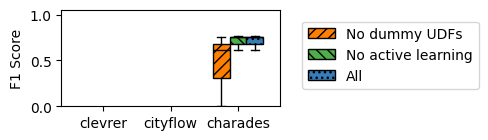

In [4]:
def plot(plot_df):
    CB_color_cycle = ['#ff7f00', '#4daf4a', '#377eb8',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    hatch_patterns = ['///', '\\\\\\', '...', 'xxx', '***', '+++', '|||', '---', 'ooo']
    # selection_methods = ['All', 'No Active Learning']
    selection_methods = ['No Dummy UDF', 'No Active Learning', 'All']
    selection_method_labels = ['No dummy UDFs', 'No active learning', 'All']
    num_selection_methods = len(selection_methods)
    datasets = ['clevrer', 'cityflow', 'charades']
    # dataset_labels = ['CLEVRER', 'CityFlow-NL', 'Charades']
    num_datasets = len(datasets)
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    handles = []
    # Create a boxplot
    for i, selection_method in enumerate(selection_methods):
        group = plot_df[plot_df['selection_method'] == selection_method]
        bp_f1 = ax.boxplot(
            [group[group['dataset'] == d]['f1_score'] for d in datasets],
            positions=np.array(range(num_datasets)) * (num_selection_methods + 1) + i,
            sym='.',
            widths=1,
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
            medianprops=dict(color='black'))
        handles.append(bp_f1["boxes"][0])

    # Customize the plot labels and legend
    # ax.set_title(f"question_ids: {question_ids}")
    ax.set(ylabel="F1 Score")
    # ax.set(xlabel="# new UDFs")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlim(left=-1.5, right=num_datasets * (num_selection_methods + 1) - 0.5)
    ax.set_xticks(np.arange(num_selection_methods / 2 - 0.5, num_datasets * num_selection_methods + num_selection_methods / 2 + 1, num_selection_methods + 1))
    ax.set_xticklabels(datasets)
    # fig.legend(handles, selection_methods, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, prop={"size": 10}, fancybox=True, shadow=False) # On the top
    fig.legend(handles, selection_method_labels, loc='center left', bbox_to_anchor=(1, 0.6), ncol=1, prop={"size": 10}, fancybox=True, shadow=False) # On the right
    fig.tight_layout()
    fig.savefig(f"figures/ablation_udf_selection.pdf", bbox_inches='tight')

    plt.show()

plot(plot_df)

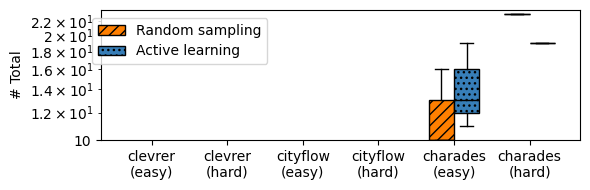

In [5]:
def count_plot(count_df):
    CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    hatch_patterns = ['///', '...', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    methods = ['random', 'active']
    method_labels = ['Random sampling', 'Active learning']
    num_methods = len(methods)
    datasets = [('clevrer', 'easy'), ('clevrer', 'hard'), ('cityflow', 'easy'), ('cityflow', 'hard'), ('charades', 'easy'), ('charades', 'hard')]
    xticklabels = [f"{d}\n({l})" for d, l in datasets]
    # dataset_labels = ['CLEVRER', 'CityFlow-NL', 'Charades']
    num_datasets = len(datasets)
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(num_datasets, 2))
    handles = []
    # Create a boxplot
    for i, method in enumerate(methods):
        group = count_df[count_df['method'] == method]
        bp_f1 = ax.boxplot(
            [group[(group['dataset'] == d) & (group['level'] == l)]['ntotal'] for d, l in datasets],
            positions=np.array(range(num_datasets)) * (num_methods + 1) + i,
            sym='.',
            widths=1,
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
            medianprops=dict(color='black'))
        handles.append(bp_f1["boxes"][0])

    # Customize the plot labels and legend
    # ax.set_title(f"question_ids: {question_ids}")
    ax.set(ylabel="# Total")
    # ax.set(xlabel="# new UDFs")
    ax.set_ylim(bottom=10)
    # log scale
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_xlim(left=-1.5, right=num_datasets * (num_methods + 1) - 0.5)
    ax.set_xticks(np.arange(num_methods / 2 - 0.5, num_datasets * (num_methods + 1) + num_methods / 2 - 0.5 - 1e-7, num_methods + 1))
    ax.set_xticklabels(xticklabels)
    fig.legend(handles, method_labels, loc='upper left', bbox_to_anchor=(0.15, 0.92), ncol=1, prop={"size": 10}, fancybox=True, shadow=False) # Top left
    # fig.legend(handles, method_labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=2, prop={"size": 10}, fancybox=True, shadow=False) # On the top
    # fig.legend(handles, method_labels, loc='center left', bbox_to_anchor=(1, 0.6), ncol=2, prop={"size": 10}, fancybox=True, shadow=False) # On the right
    fig.tight_layout()
    fig.savefig(f"figures/ablation_pos_count.pdf", bbox_inches='tight')

    plt.show()

count_plot(count_df)

In [6]:
print("active cityflow", len(count_df[(count_df['method'] == 'active') & (count_df['dataset'] == 'cityflow')]))
print("active clevrer", len(count_df[(count_df['method'] == 'active') & (count_df['dataset'] == 'clevrer') ]))
print("active charades", len(count_df[(count_df['method'] == 'active') & (count_df['dataset'] == 'charades')]))
print("active", len(count_df[(count_df['method'] == 'active')]))

print("random cityflow", len(count_df[(count_df['method'] == 'random') & (count_df['dataset'] == 'cityflow') ]))
print("random clevrer", len(count_df[(count_df['method'] == 'random') & (count_df['dataset'] == 'clevrer')]))
print("random charades", len(count_df[(count_df['method'] == 'random') & (count_df['dataset'] == 'charades') ]))
print("random", len(count_df[(count_df['method'] == 'random')]))


active cityflow 0
active clevrer 0
active charades 4
active 4
random cityflow 0
random clevrer 0
random charades 4
random 4


In [7]:
# For each udf_name under 'easy' and 'charades', compare the average of ntotal for active and random
easy_charades = count_df[(count_df['level'] == 'easy') & (count_df['dataset'] == 'charades')]

easy_charades_active = easy_charades[easy_charades['method'] == 'active']
easy_charades_random = easy_charades[easy_charades['method'] == 'random']

print(easy_charades_active.groupby('udf_name')['ntotal'].mean())
print(easy_charades_random.groupby('udf_name')['ntotal'].mean())


udf_name
beneath    19.0
in         12.0
Name: ntotal, dtype: float64
udf_name
beneath    16.0
in         10.0
Name: ntotal, dtype: float64
